In [1]:
import torch
import numpy as np

import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:

class Assign_Model(nn.Module):
    
    def __init__(self,in_size,hidden1_size,hidden2_size,out_size):
        super().__init__()
        
        self.input_l = nn.Linear(in_size,hidden1_size)
        
        self.hidden1_l = nn.Linear(hidden1_size,hidden2_size)
        
        self.hidden2_l = nn.Linear(hidden2_size,out_size)
        
    def forward(self,features):
        
        out_i = self.input_l( features )
        
        act_h1 = torch.tanh( out_i )
        
        out_h1 = self.hidden1_l( act_h1 )
        
        act_h2 = torch.tanh( out_h1 )
        
        Final_out = self.hidden2_l( act_h2 )
        
        return Final_out
        


# Task 2b: Image Data Classifcation



### Extracting data

In [3]:
inputs = np.genfromtxt('Data/task2b/Image_data_dim60.txt',delimiter = '\t')
labels = np.genfromtxt('Data/task2b/image_data_labels.txt',delimiter = '\n')

labels = labels.reshape((len(labels),1))
inputs = np.append(inputs,labels,axis = 1)
inputs = inputs[ inputs[:,60] != 0 ]
inputs = inputs[ inputs[:,60] != 2 ]
inputs = inputs[ inputs[:,60] != 3 ]

temp = np.zeros((len(inputs),60))
temp = np.append(temp, np.ones((len(inputs),1)),axis = 1)
X = (temp == 1)


Y0 = (X*np.array([(inputs[:,60] == 1)]*61).T)
Y1 = (X*np.array([(inputs[:,60] == 4)]*61).T)
Y2 = (X*np.array([(inputs[:,60] == 5)]*61).T)
Y3 = (X*np.array([(inputs[:,60] == 6)]*61).T)
Y4 = (X*np.array([(inputs[:,60] == 7)]*61).T)

inputs[Y0] = 0
inputs[Y1] = 1
inputs[Y2] = 2
inputs[Y3] = 3
inputs[Y4] = 4


# print(inputs)
np.random.shuffle(inputs)


train, rem = np.split( inputs, [int(0.7 * len(inputs))] , axis = 0)

val , test   = np.split( rem , [int(0.33333 * len(rem))] , axis = 0)

print(len(train))
print(len(val))
print(len(test))

train = torch.from_numpy(train).float()
test  = torch.from_numpy(test).float()
val   = torch.from_numpy(val).float()

1232
175
353


### Image Classification model


In [4]:
Image_Model1 = Assign_Model(60,100,100,5)
Image_Model2 = Assign_Model(60,100,100,5)
Image_Model3 = Assign_Model(60,100,100,5)

In [5]:
torch.save(Image_Model1.state_dict(), 'Task2b_Initial.pth')

Image_Model2.load_state_dict(torch.load('Task2b_Initial.pth'))

Image_Model3.load_state_dict(torch.load('Task2b_Initial.pth'))

Delta_w = []
for param in Image_Model1.parameters():
    Delta_w.append(torch.zeros(param.size()))
    
    
loss_fn = F.cross_entropy


lr = 1e-5

al = 0.9
opt = torch.optim.Adam(Image_Model3.parameters(), lr=1e-5 , betas = (0.9,0.999))

### Training Phase Generalized Delta



In [6]:
Average_loss = []
num_epochs = 1500
for epoch in range(num_epochs):
    
    
    Total_loss_Train = 0
    for X in train:
        preds = Image_Model1(X[:60])
        preds = torch.unsqueeze(preds,0)
        loss = loss_fn(preds,torch.unsqueeze(X[60],0).long())
        
        Total_loss_Train += loss.item()
        loss.backward()
        
        with torch.no_grad():
            
             i = 0
             for param in Image_Model1.parameters():
                
                 Delta_w[i] =  - (lr*param.grad) + (al*Delta_w[i])
                
                 param += (Delta_w[i])
                
                 param.grad.zero_()
                
                 i += 1
    Average_loss.append(Total_loss_Train/len(train))      

    if Average_loss[-1] <= 0.01:
        break
    if (epoch+1) % 100  == 0:
         print('Epoch [{}/{}], Average_Loss_Train: {:.4f}'.format(epoch+1,num_epochs,Average_loss[-1]))

Epoch [100/1500], Average_Loss_Train: 0.9432
Epoch [200/1500], Average_Loss_Train: 0.7403
Epoch [300/1500], Average_Loss_Train: 0.5628
Epoch [400/1500], Average_Loss_Train: 0.3967
Epoch [500/1500], Average_Loss_Train: 0.2507
Epoch [600/1500], Average_Loss_Train: 0.1446
Epoch [700/1500], Average_Loss_Train: 0.0833
Epoch [800/1500], Average_Loss_Train: 0.0514
Epoch [900/1500], Average_Loss_Train: 0.0345
Epoch [1000/1500], Average_Loss_Train: 0.0248
Epoch [1100/1500], Average_Loss_Train: 0.0188
Epoch [1200/1500], Average_Loss_Train: 0.0149
Epoch [1300/1500], Average_Loss_Train: 0.0122
Epoch [1400/1500], Average_Loss_Train: 0.0102


### Training Phase Delta rule

In [39]:
Average_loss2 = []
num_epochs = 8000
for epoch in range(num_epochs):
    
    
    Total_loss_Train = 0
    for X in train:
        preds = Image_Model2(X[:60])
        preds = torch.unsqueeze(preds,0)
        loss = loss_fn(preds,torch.unsqueeze(X[60],0).long())
        
        Total_loss_Train += loss.item()
        loss.backward()
        
        with torch.no_grad():

             for param in Image_Model2.parameters():
                
                 param += - (lr*param.grad)
                 param.grad.zero_()
                
    Average_loss2.append(Total_loss_Train/len(train))      
    
    if Average_loss2[-1] <= 0.01:
        break
    if (epoch+1) % 500  == 0:
         print('Epoch [{}/{}], Average_Loss_Train: {:.4f}'.format(epoch+1,num_epochs,Average_loss2[-1]))

Epoch [500/8000], Average_Loss_Train: 0.0318
Epoch [1000/8000], Average_Loss_Train: 0.0269
Epoch [1500/8000], Average_Loss_Train: 0.0231
Epoch [2000/8000], Average_Loss_Train: 0.0202
Epoch [2500/8000], Average_Loss_Train: 0.0178
Epoch [3000/8000], Average_Loss_Train: 0.0159
Epoch [3500/8000], Average_Loss_Train: 0.0142
Epoch [4000/8000], Average_Loss_Train: 0.0129
Epoch [4500/8000], Average_Loss_Train: 0.0118
Epoch [5000/8000], Average_Loss_Train: 0.0108


### Training Phase Adam method

In [8]:
Average_loss3 = []
num_epochs = 1500
for epoch in range(num_epochs):
    
    
    Total_loss_Train = 0
    for X in train:
        preds = Image_Model3(X[:60])
        preds = torch.unsqueeze(preds,0)
        loss = loss_fn(preds,torch.unsqueeze(X[60],0).long())
        
        Total_loss_Train += loss.item()
        loss.backward()
        
        opt.step()
        opt.zero_grad()
                
    Average_loss3.append(Total_loss_Train/len(train))      
    
    if Average_loss3[-1] <= 0.01:
        break
    if (epoch+1) % 100  == 0:
         print('Epoch [{}/{}], Average_Loss_Train: {:.4f}'.format(epoch+1,num_epochs,Average_loss3[-1]))

Epoch [100/1500], Average_Loss_Train: 0.8007
Epoch [200/1500], Average_Loss_Train: 0.5689
Epoch [300/1500], Average_Loss_Train: 0.3290
Epoch [400/1500], Average_Loss_Train: 0.1281
Epoch [500/1500], Average_Loss_Train: 0.0254


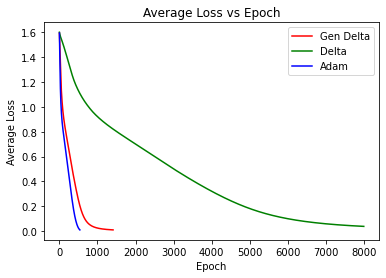

In [9]:

plt.plot(range(0,len(Average_loss)), Average_loss,color='r', label='Gen Delta')
plt.plot(range(0,len(Average_loss2)), Average_loss2,color='g', label='Delta')
plt.plot(range(0,len(Average_loss3)), Average_loss3,color='b', label='Adam')

plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title("Average Loss vs Epoch")
plt.legend()

In [43]:
actual = train[:,60]

preds = Image_Model1(train[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Genralized Delta Rule:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))

preds = Image_Model2(train[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Delta Rule:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))


preds = Image_Model3(train[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Adam:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))


Genralized Delta Rule:
 [[233   0   0   0   0]
 [  0 267   0   0   0]
 [  0   0 280   0   0]
 [  0   0   0 211   0]
 [  0   0   0   0 241]] 
 Accuarcy = 1.0 

Delta Rule:
 [[233   0   0   0   0]
 [  0 267   0   0   0]
 [  0   0 280   0   0]
 [  0   0   0 211   0]
 [  0   0   0   0 241]] 
 Accuarcy = 1.0 

Adam:
 [[233   0   0   0   0]
 [  0 267   0   0   0]
 [  0   0 280   0   0]
 [  0   0   0 211   0]
 [  0   0   0   0 241]] 
 Accuarcy = 1.0 



In [44]:
actual = test[:,60]

preds = Image_Model1(test[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Genralized Delta Rule:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))

preds = Image_Model2(test[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Delta Rule:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))


preds = Image_Model3(test[:,:60])
preds = torch.argmax(preds,1)

X = (preds == actual).float() 
print('Adam:\n',confusion_matrix(actual,preds) ,"\n", 'Accuarcy = {} \n'.format(torch.mean(X)))


Genralized Delta Rule:
 [[43  2  7  2 11]
 [ 4 27  9  4 18]
 [ 7 12 62  1  6]
 [ 1  6  2 40  7]
 [ 3 15  6  7 51]] 
 Accuarcy = 0.6317280530929565 

Delta Rule:
 [[45  2  9  1  8]
 [ 5 30  9  4 14]
 [ 7 16 58  2  5]
 [ 1  8  1 42  4]
 [ 4 21  8  8 41]] 
 Accuarcy = 0.6118980050086975 

Adam:
 [[45  3  9  1  7]
 [ 4 35 10  2 11]
 [ 7 13 62  1  5]
 [ 0  3  2 43  8]
 [ 3 15  9 10 45]] 
 Accuarcy = 0.6515581011772156 



In [42]:
print('Total Epochs Gen_delta :',len(Average_loss))
print('Total Epochs delta :',8000+len(Average_loss2))
print('Total Epochs Adam :',len(Average_loss3))

Total Epochs Gen_delta : 1411
Total Epochs delta : 13474
Total Epochs Adam : 539
